# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Введение

## Подготовка данных

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import category_encoders as ce
from sklearn.model_selection import train_test_split
import lightgbm as ltb
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [30]:
data = pd.read_csv('/datasets/autos.csv')

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [32]:
data['Repaired'] = data['Repaired'].fillna('unknown')

In [33]:
data = data.drop_duplicates()

<AxesSubplot:ylabel='Price'>

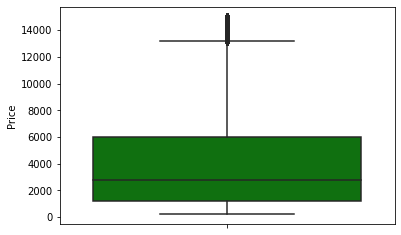

In [34]:
data = data.loc[(data['Price'] > 200) & (data['Price'] < 15000)]

display(sns.boxplot(y="Price", color='g', data=data))

In [35]:
data['Kilometer'].describe()

count    319429.000000
mean     130204.568151
std       35714.620299
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

In [36]:
data['DateCrawled'].max()

'2016-04-07 14:36:58'

count    319429.000000
mean       2003.685517
std          65.383965
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2007.000000
max        9999.000000
Name: RegistrationYear, dtype: float64


<AxesSubplot:ylabel='RegistrationYear'>

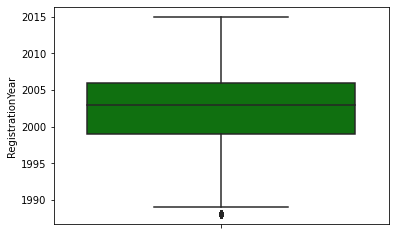

In [37]:
print(data['RegistrationYear'].describe())

data = data.loc[(data['RegistrationYear'] > 1987) & (data['RegistrationYear'] < 2016)]
display(sns.boxplot(y="RegistrationYear", color='g', data=data))

count    291898.000000
mean        111.438078
std         179.992799
min           0.000000
25%          75.000000
50%         105.000000
75%         140.000000
max       20000.000000
Name: Power, dtype: float64


<AxesSubplot:ylabel='Power'>

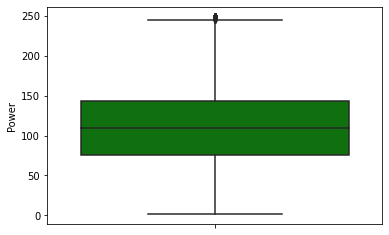

In [38]:
print(data['Power'].describe())

data = data.loc[(data['Power'] > 0) & (data['Power'] < 250)]
display(sns.boxplot(y="Power", color='g', data=data))

In [14]:
data['VehicleType'] = data['VehicleType'].fillna('unknown')

In [15]:
data = data.dropna(subset=['Model'])

In [16]:
data['FuelType'].value_counts()

data['FuelType'] = data['FuelType'].fillna('petrol')

In [17]:
data['Gearbox'].value_counts()


data['Gearbox'] = data['Gearbox'].fillna('manual')

In [18]:
data.reset_index(drop=True, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252199 entries, 0 to 252198
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        252199 non-null  object
 1   Price              252199 non-null  int64 
 2   VehicleType        252199 non-null  object
 3   RegistrationYear   252199 non-null  int64 
 4   Gearbox            252199 non-null  object
 5   Power              252199 non-null  int64 
 6   Model              252199 non-null  object
 7   Kilometer          252199 non-null  int64 
 8   RegistrationMonth  252199 non-null  int64 
 9   FuelType           252199 non-null  object
 10  Brand              252199 non-null  object
 11  Repaired           252199 non-null  object
 12  DateCreated        252199 non-null  object
 13  NumberOfPictures   252199 non-null  int64 
 14  PostalCode         252199 non-null  int64 
 15  LastSeen           252199 non-null  object
dtypes: int64(7), object(

In [19]:
data = data.drop(['DateCrawled', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'DateCreated'], axis=1)

In [20]:
data.corr()

,Price,RegistrationYear,Power,Kilometer
Price,1.000000,0.680334,0.456771,-0.363676
RegistrationYear,0.680334,1.000000,0.128090,-0.412237
Power,0.456771,0.128090,1.000000,0.161246
Kilometer,-0.363676,-0.412237,0.161246,1.000000


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252199 entries, 0 to 252198
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             252199 non-null  int64 
 1   VehicleType       252199 non-null  object
 2   RegistrationYear  252199 non-null  int64 
 3   Gearbox           252199 non-null  object
 4   Power             252199 non-null  int64 
 5   Model             252199 non-null  object
 6   Kilometer         252199 non-null  int64 
 7   FuelType          252199 non-null  object
 8   Brand             252199 non-null  object
 9   Repaired          252199 non-null  object
dtypes: int64(4), object(6)
memory usage: 19.2+ MB


In [22]:
data = data.drop('Model', axis=1) # удаление категорийного столбца Model необходимо, так как моделей машин очень много и это не будет влиять на обучение, то есть данный столбцец не является информативным

In [23]:
target = data['Price']
features = data.drop(['Price'] , axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.2, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

In [24]:
# кодировка категориальных переменных
cat = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired', 'Brand']
# тренировочные данные
encoder = ce.TargetEncoder(cols=cat)


encoder.fit(features_train, target_train)

features_train = encoder.transform(features_train)

# валидационные данные

features_valid = encoder.transform(features_valid)

# тестовые данные

features_test = encoder.transform(features_test)

In [25]:
num = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired', 'Brand', 'RegistrationYear', 'Power', 'Kilometer']
scaler = StandardScaler()
scaler.fit(features_train)
features_train[num] = scaler.transform(features_train[num])
features_valid[num] = scaler.transform(features_valid[num])
features_test[num] = scaler.transform(features_test[num])

## Анализ моделей

**LightGBM**

In [26]:
%%time
lgbr = ltb.LGBMRegressor(random_seed=12345, n_estimators=100, num_leaves=100) 

lgbr.fit(features_train, target_train,
        eval_set=[(features_valid, target_valid)],
        eval_metric='rmse', verbose=10,
        early_stopping_rounds=100)
        
predict_valid = lgbr.predict(features_valid)
        
print((mean_squared_error(target_valid, predict_valid))**0.5)

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's rmse: 1937.57	valid_0's l2: 3.75418e+06
[20]	valid_0's rmse: 1504.54	valid_0's l2: 2.26365e+06
[30]	valid_0's rmse: 1391.75	valid_0's l2: 1.93698e+06
[40]	valid_0's rmse: 1348.79	valid_0's l2: 1.81923e+06
[50]	valid_0's rmse: 1328.68	valid_0's l2: 1.7654e+06
[60]	valid_0's rmse: 1314.57	valid_0's l2: 1.72808e+06
[70]	valid_0's rmse: 1305.78	valid_0's l2: 1.70506e+06
[80]	valid_0's rmse: 1298.76	valid_0's l2: 1.68679e+06
[90]	valid_0's rmse: 1293.51	valid_0's l2: 1.67317e+06
[100]	valid_0's rmse: 1290.21	valid_0's l2: 1.66463e+06
1290.2057682129503
CPU times: user 46.1 s, sys: 271 ms, total: 46.4 s
Wall time: 47.9 s


**Лес деревьев**

In [27]:
%%time
best_result = 2500
best_est = 0
best_depth = 0

for est in range(80, 101, 10):
    for depth in range (10, 15):
        model = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth) 

        model.fit(features_train, target_train)
        
        predict_valid = model.predict(features_valid)
        
        result = (mean_squared_error(target_valid, predict_valid))**0.5

        if result < best_result:
            best_result = result
            best_est = est
            best_depth = depth

print(best_result)    
print(best_est)
print(best_depth)

1292.5242870703562
100
14
CPU times: user 5min 2s, sys: 570 ms, total: 5min 3s
Wall time: 5min 3s


In [28]:
%%time
model = RandomForestRegressor(random_state=12345, n_estimators=100, max_depth=14) 
model.fit(features_train, target_train)
        
predict_valid = model.predict(features_valid)
        
print((mean_squared_error(target_valid, predict_valid))**0.5)

1292.5242870703562
CPU times: user 25.3 s, sys: 116 ms, total: 25.4 s
Wall time: 25.5 s


**Дерево решений**

In [29]:
%%time
best_result = 2500
best_depth = 0

for depth in range (1, 15):
        result = []
        model_tree = DecisionTreeRegressor(random_state=12345, max_depth=depth)
        model_tree = model_tree.fit(features_train, target_train)
        predict_valid = model_tree.predict(features_valid)

        result = (mean_squared_error(target_valid, predict_valid))**0.5
        if result < best_result:
            best_result = result
            best_depth = depth

print(best_result)
print(best_depth)

1407.8023491306537
14
CPU times: user 3.11 s, sys: 4.05 ms, total: 3.11 s
Wall time: 3.12 s


In [30]:
%%time
model_tree = DecisionTreeRegressor(random_state=12345, max_depth=depth)
model_tree = model_tree.fit(features_train, target_train)
predict_valid = model_tree.predict(features_valid)
print((mean_squared_error(target_valid, predict_valid))**0.5)

1407.8023491306537
CPU times: user 371 ms, sys: 0 ns, total: 371 ms
Wall time: 376 ms


**Линейная регрессия**

In [31]:
%%time
model_lin = LinearRegression()

model_lin.fit(features_train, target_train)
predict_valid = model_lin.predict(features_valid)
(mean_squared_error(target_valid, predict_valid))**0.5

CPU times: user 62.1 ms, sys: 99.4 ms, total: 161 ms
Wall time: 108 ms


2030.5175847269047

**Вывод**

Лучше всего показала себя модель LightGBM с метрикой rmse, равной 1290, также время обучения модели составляет 8,7, что также является хорошим результатом.

In [ ]:
%%time
lgbr = ltb.LGBMRegressor(random_seed=12345, n_estimators=100, num_leaves=100) 

lgbr.fit(features_train, target_train,
        eval_set=[(features_test, target_test)],
        eval_metric='rmse', verbose=10,
        early_stopping_rounds=100)
        
predict_test = lgbr.predict(features_test)
        
print((mean_squared_error(target_test, predict_test))**0.5)

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's rmse: 1931.96	valid_0's l2: 3.73246e+06
[20]	valid_0's rmse: 1503.28	valid_0's l2: 2.25985e+06


In [ ]:
predict_constant = pd.Series([data['Price'].mean()] * len(target_test))
print((mean_squared_error(target_test, predict_constant))**0.5)

**Вывод**
На начальном этапе была проведена предобработка данных.

По результатам предобработки данных были выполнены следующие пункты:

1) Удалены дубликаты;

2) В категориальных столбцах VehicleType, Repaired были заполнены пропуски путем замены их на значение unknown;

3) В столбце Model были удалены все пропуски;

4) В столцах FuelType и Gearbox значения были заменены на наиболее часто встречающиеся;

5) Были удалены аномальные значения в столбце с ценой, согласно графику boxplot;

6) Были удалены аномальные значения в столбце с лошадиными силами, согласно графику boxplot;

7) Были удалены аномальные значения в столбце с годом выпуска, согласно графику boxplot;

8) Также были удалены столбцы с датами, так как они не влияют на цену автомобиля, также данные о заказчикке и количество картинок не влияет на цену автомобиля. Эти данные были полезные при предобработке, однако впоследствии их применение для машинного обучения не является информативным, так как они будут делать обучение более долгим и могут негативно влиять на само обучение. Также был удален столбец Model, так как он не является информативным.

Далее данные были разделены на тестовую, валидационную и тренировочную выборки в отношении 80:10:10 соответственно. Далее были закодированы категорийные признаки и все признаки были масштабированы.

Итоговое RMSE модели составило 1291. Что является хорошим результатом. Лудшая модель - Light GBM. Количество листьев - 100, количество деревьев - 100. Время обучения модели - 12 секунд.

Также модель была сравнена с константной, которая предсказывает все время среднее значение. Значение RMSE у модели намного лучше, что говорит об адекватности модели.